In [12]:
import numpy as np
from msdm.domains import GridWorld
from msdm.core.problemclasses.mdp import TabularPolicy,TabularMarkovDecisionProcess
from msdm.core.assignment import AssignmentMap
import matplotlib.pyplot as plt
from scipy.special import softmax, logsumexp
from msdm.core.algorithmclasses import Plans, Result
from msdm.domains.gridworld.plotting import GridWorldPlotter
from matplotlib.patches import Rectangle, Arrow, Circle

In [17]:
defaultparams = dict(
    initial_features=('s',),
    absorbing_features=('g',),
    wall_features=('#',),
    default_features=('.',),
    feature_rewards={
        'g': 0,
        'x': -20
    },
    step_cost=-1,
)

gw = GridWorld(
    tile_array=[
        '..#..g',
        '..#...',
        '..#...',
        's.....',
    ],
    **defaultparams
)

# parameters
mdp = gw
S = mdp.state_list # set of all states from MDP
A = mdp.action_list # set of all actions from MDP
P = mdp.transitionmatrix # state transition function
# P is sparse: vector representation > huge (think of as function)
R = mdp.rewardmatrix# reward function
th = 0.1 # threshold, th > 0 
d = 1 #discount factor

value_iter = ValueIteration(gw)
output = value_iter.Iterate()

(-0.30000000000000004, 6.3, -0.2, 4.2)

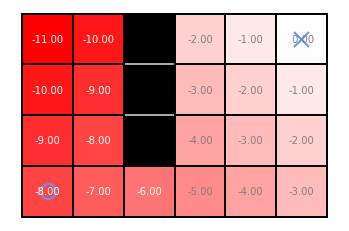

In [24]:
gwp = gw.plot().plot_state_map(output['value'])
gwp.ax.axis('equal')

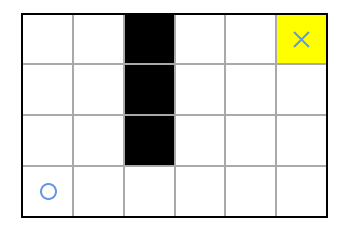

In [22]:
from msdm.domains.gridworld.plotting import GridWorldPlotter
featureColors = {
        'g': 'yellow',
        'x': 'red',
    }
edgecolor='darkgrey'
facecolor='k'
figsizeMult=1
figsize = (gw.width * figsizeMult,gw.height * figsizeMult)
_, ax = plt.subplots(1, 1, figsize=figsize)
gwp = GridWorldPlotter(gw,ax)
"""ss = gw._states
for s in ss:
    if s=={'x': -1, 'y': -1}:
        continue
    xy = (s['x'], s['y'])
    f = gw._locFeatures.get(s, '.')[0]
    color = featureColors.get(f, 'w')
    square = Rectangle(xy, 1, 1,
                       facecolor=color,
                       edgecolor=edgecolor,
                       linewidth=2)"""
#gwp.ax.add_patch(square)
gwp.ax.axis('equal')
gwp.plot_features(featureColors)
gwp.plot_walls()
gwp.plot_initial_states()
gwp.plot_absorbing_states()
gwp.plot_outer_box()

AxesSubplot(0.125,0.125;0.775x0.755)


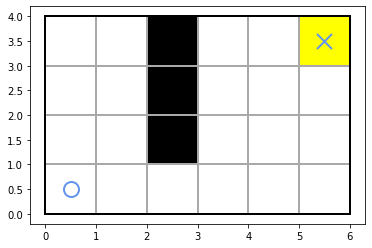

In [15]:
from msdm.domains.gridworld.plotting import GridWorldPlotter
from matplotlib.patches import Rectangle, Arrow, Circle
featureColors = {
        'g': 'yellow',
        'x': 'red',
    }
figsizeMult=1
figsize = (gw.width * figsizeMult,gw.height * figsizeMult)
_, ax = plt.subplots(1, 1, figsize=figsize)

#from pprint import pprint
#pprint(vars(gw))

edgecolor='darkgrey'
facecolor='k'
TERMINALSTATE = {'x': -1, 'y': -1}
ss = gw._states
for s in ss:
    if s == TERMINALSTATE:
        continue
    xy = (s['x'], s['y'])
    f = gw._locFeatures.get(s, '.')[0]
    color = featureColors.get(f, 'w')
    square = Rectangle(xy, 1, 1,
                       facecolor=color,
                       edgecolor=edgecolor,
                       linewidth=2)
    ax.add_patch(square)
    
for ws in gw.walls:
    xy = (ws['x'], ws['y'])
    square = Rectangle(xy, 1, 1,
                       facecolor=facecolor,
                       edgecolor=edgecolor,
                       linewidth=2)
    ax.add_patch(square)    

markerSize = 15
for s in gw._initStates:
    x, y = s['x'], s['y']
    ax.plot(x + .5, y + .5,
                 markeredgecolor='cornflowerblue',
                 marker='o',
                 markersize=markerSize,
                 markeredgewidth=2,
                 fillstyle='none')

for s in gw._absorbingStates:
    # sdict = dict(zip([v.name for v in s.variables], s.values))
    # x, y = sdict['x'], sdict['y']
    x, y = s['x'], s['y']
    ax.plot(x + .5, y + .5,
                 markeredgecolor='cornflowerblue',
                 marker='x',
                 markersize=markerSize,
                 markeredgewidth=2)    

outerbox = Rectangle((0, 0), gw.width, gw.height,
                     fill=False, edgecolor='black',
                     linewidth=2)
ax.add_patch(outerbox)        
    
ax.plot()
print(ax)

In [16]:
class ValueIteration:
    def __init__(self, env, th = 0.01, d = 0.99):
        # pull input parameters
        self.th = th
        self.d = d
        self.max_iter = 200
        self.entreg = True
        
        # set up environment
        self.mdp = env
        self.S = self.mdp.state_list # set of all states from MDP
        self.A = self.mdp.action_list # set of all actions from MDP
        self.P = self.mdp.transitionmatrix# state transition function
        # P is sparse: vector representation > huge (think of as function)
        self.R = self.mdp.rewardmatrix# reward function
        
    def Iterate(self):
        return self.valueIteration()
        
    def valueIteration(self):
        # initialize
        S = self.S
        A = self.A
        P = self.P
        R = self.R
        V = AssignmentMap([(s,0) for s in S])
        
        for count in range(self.max_iter):
            dif = 0  
            # update value for each state
            for s in S:
                #print(s)
                v = V[s]
                # go through all actions
                qi = np.zeros(len(A))
                Q = AssignmentMap([(a,0) for a in A])
                # print(Q)
                for a in A:
                    # p = probabilty, n = next state, r = reward
                    s_i = S.index(s)
                    a_i = A.index(a)
                    for i in range(len(S)):
                        #print(a.keys())
                        old_q = Q[a]
                        p = P[s_i][a_i][i]
                        n = S[i]
                        r = R[s_i][a_i][i]
                        #if r != 0:
                            #print(p,n,r)
                        new_q = old_q + p * (r + d * V[n])
                        Q[a] = new_q
                        #print(new_q)
                max_q = -float("inf")
                #print(Q)
                for k,q in Q.items():
                    if q > max_q:
                        max_q = q
                V[s] = max_q
                dif = max(dif, abs(v - V[s]))
                #print(dif)
            #print(v,V[s])
            if dif < th:
                break

        # create policy
        policy = AssignmentMap()
        Q = AssignmentMap()
        for s in S:
            Q[s] = AssignmentMap([(a,0) for a in A])
            for a in A:
                # p = probabilty, n = next state, r = reward
                s_i = S.index(s)
                a_i = A.index(a)
                for i in range(len(S)):
                        #print(a.keys())
                        old_q = Q[s][a]
                        p = P[s_i][a_i][i]
                        n = S[i]
                        r = R[s_i][a_i][i]
                        new_q = old_q + p * (r + d * V[n])
                        Q[s][a] = new_q
            max_q = 0
            max_idx = -1
            for k,v in AssignmentMap.items(Q[s]):
                    if v > max_q:
                        max_q = v
                        max_idx = k
            opt_action = max_idx
            policy[s] = AssignmentMap()
            policy[s][opt_action] = 1
        
        # Create results   
        """if self.entreg:
            pi = softmax((1 / 1) * q, axis=-1)
        else:
            pi = np.log(np.zeros_like(q))
            pi[q == np.max(q, axis=-1, keepdims=True)] = 1
            pi = softmax(pi, axis=-1)
        res = Result()
        res.mdp = self.mdp
        res.policy = res.pi = TabularPolicy(mdp._states, mdp._actions, policydict=policy)
        res._valuevec = V
        vf = AssignmentMap([(s, vi) for s, vi in zip(self.S, V)])
        res.valuefunc = res.V = vf
        res.actionvaluefunc = res.Q = Q
        return res"""
        
        return {'value':V, 'policy':Q}

In [5]:
defaultparams = dict(
    initial_features=('s',),
    absorbing_features=('g',),
    wall_features=('#',),
    default_features=('.',),
    feature_rewards={
        'g': 0,
        'x': -20
    },
    step_cost=-1,
)

gw = GridWorld(
    tile_array=[
        '..#..g',
        '..#...',
        '..#...',
        's.....',
    ],
    **defaultparams
)

In [42]:
# parameters
mdp = gw
S = mdp.state_list # set of all states from MDP
A = mdp.action_list # set of all actions from MDP
P = mdp.transitionmatrix # state transition function
# P is sparse: vector representation > huge (think of as function)
R = mdp.rewardmatrix# reward function
th = 0.1 # threshold, th > 0 
d = 1 #discount factor

In [77]:
for ai, a in enumerate(A):
    print(ai,a)
    print(a.get('dx',0))

0 {'dx': -1, 'dy': 0}
-1
1 {'dy': -1, 'dx': 0}
0
2 {'dx': 0, 'dy': 0}
0
3 {'dy': 1, 'dx': 0}
0
4 {'dx': 1, 'dy': 0}
1


In [106]:
# initialize
V = AssignmentMap([(s,0) for s in S])
dif = 100
while dif >= th:
    dif = 0  
    # update value for each state
    for s in S:
        print(s)
        v = V[s]
        # go through all actions
        qi = np.zeros(len(A))
        Q = AssignmentMap([(a,0) for a in A])
        # print(Q)
        for a in A:
            # p = probabilty, n = next state, r = reward
            s_i = S.index(s)
            a_i = A.index(a)
            for i in range(len(S)):
                #print(a.keys())
                old_q = Q[a]
                p = P[s_i][a_i][i]
                n = S[i]
                r = R[s_i][a_i][i]
                if r != 0:
                    print(p,n,r)
                new_q = old_q + p * (r + d * V[n])
                Q[a] = new_q
        max_q = 0
        for k,v in AssignmentMap.items(Q):
            if v > max_q:
                max_q = v
        V[s] = max_q
        dif = max(dif, abs(v - V[s]))
    print(dif)

# create policy
policy = AssignmentMap()
for s in S:
    for a in range(len(A)):
        # p = probabilty, n = next state, r = reward
        s_i = S.index(s)
        a_i = A.index(a)
        Q = AssignmentMap([(a,0) for a in A])
        for i in range(len(S)):
                #print(a.keys())
                old_q = Q[a]
                p = P[s_i][a_i][i]
                n = S[i]
                r = R[s_i][a_i][i]
                new_q = old_q + p * (r + d * V[n])
                Q[a] = new_q
    max_q = 0
    max_idx = -1
    for k,v in AssignmentMap.items(Q):
            if v > max_q:
                max_q = v
                max_idx = k
    opt_action = max_idx
    policy[s] = Assignmentmap()
    policy[s][opt_action] = 1

{'x': -1, 'y': -1}
{'x': 0, 'y': 0}
1.0 {'x': 0, 'y': 0} -1.0
1.0 {'x': 0, 'y': 0} -1.0
1.0 {'x': 0, 'y': 0} -1.0
1.0 {'x': 0, 'y': 1} -1.0
1.0 {'x': 1, 'y': 0} -1.0
{'x': 0, 'y': 1}
1.0 {'x': 0, 'y': 1} -1.0
1.0 {'x': 0, 'y': 0} -1.0
1.0 {'x': 0, 'y': 1} -1.0
1.0 {'x': 0, 'y': 2} -1.0
1.0 {'x': 1, 'y': 1} -1.0
{'x': 0, 'y': 2}
1.0 {'x': 0, 'y': 2} -1.0
1.0 {'x': 0, 'y': 1} -1.0
1.0 {'x': 0, 'y': 2} -1.0
1.0 {'x': 0, 'y': 3} -1.0
1.0 {'x': 1, 'y': 2} -1.0
{'x': 0, 'y': 3}
1.0 {'x': 0, 'y': 3} -1.0
1.0 {'x': 0, 'y': 2} -1.0
1.0 {'x': 0, 'y': 3} -1.0
1.0 {'x': 0, 'y': 3} -1.0
1.0 {'x': 1, 'y': 3} -1.0
{'x': 1, 'y': 0}
1.0 {'x': 0, 'y': 0} -1.0
1.0 {'x': 1, 'y': 0} -1.0
1.0 {'x': 1, 'y': 0} -1.0
1.0 {'x': 1, 'y': 1} -1.0
1.0 {'x': 2, 'y': 0} -1.0
{'x': 1, 'y': 1}
1.0 {'x': 0, 'y': 1} -1.0
1.0 {'x': 1, 'y': 0} -1.0
1.0 {'x': 1, 'y': 1} -1.0
1.0 {'x': 1, 'y': 2} -1.0
1.0 {'x': 1, 'y': 1} -1.0
{'x': 1, 'y': 2}
1.0 {'x': 0, 'y': 2} -1.0
1.0 {'x': 1, 'y': 1} -1.0
1.0 {'x': 1, 'y': 2} -1.0
1.0 

1.0 {'x': 5, 'y': 3} -1.0
{'x': 5, 'y': 0}
1.0 {'x': 4, 'y': 0} -1.0
1.0 {'x': 5, 'y': 0} -1.0
1.0 {'x': 5, 'y': 0} -1.0
1.0 {'x': 5, 'y': 1} -1.0
1.0 {'x': 5, 'y': 0} -1.0
{'x': 5, 'y': 1}
1.0 {'x': 4, 'y': 1} -1.0
1.0 {'x': 5, 'y': 0} -1.0
1.0 {'x': 5, 'y': 1} -1.0
1.0 {'x': 5, 'y': 2} -1.0
1.0 {'x': 5, 'y': 1} -1.0
{'x': 5, 'y': 2}
1.0 {'x': 4, 'y': 2} -1.0
1.0 {'x': 5, 'y': 1} -1.0
1.0 {'x': 5, 'y': 2} -1.0
1.0 {'x': 5, 'y': 3} -1.0
1.0 {'x': 5, 'y': 2} -1.0
{'x': 5, 'y': 3}
1.0
{'x': -1, 'y': -1}
{'x': 0, 'y': 0}
1.0 {'x': 0, 'y': 0} -1.0
1.0 {'x': 0, 'y': 0} -1.0
1.0 {'x': 0, 'y': 0} -1.0
1.0 {'x': 0, 'y': 1} -1.0
1.0 {'x': 1, 'y': 0} -1.0
{'x': 0, 'y': 1}
1.0 {'x': 0, 'y': 1} -1.0
1.0 {'x': 0, 'y': 0} -1.0
1.0 {'x': 0, 'y': 1} -1.0
1.0 {'x': 0, 'y': 2} -1.0
1.0 {'x': 1, 'y': 1} -1.0
{'x': 0, 'y': 2}
1.0 {'x': 0, 'y': 2} -1.0
1.0 {'x': 0, 'y': 1} -1.0
1.0 {'x': 0, 'y': 2} -1.0
1.0 {'x': 0, 'y': 3} -1.0
1.0 {'x': 1, 'y': 2} -1.0
{'x': 0, 'y': 3}
1.0 {'x': 0, 'y': 3} -1.0
1.0 {'x':

1.0 {'x': 3, 'y': 3} -1.0
1.0 {'x': 4, 'y': 3} -1.0
{'x': 4, 'y': 0}
1.0 {'x': 3, 'y': 0} -1.0
1.0 {'x': 4, 'y': 0} -1.0
1.0 {'x': 4, 'y': 0} -1.0
1.0 {'x': 4, 'y': 1} -1.0
1.0 {'x': 5, 'y': 0} -1.0
{'x': 4, 'y': 1}
1.0 {'x': 3, 'y': 1} -1.0
1.0 {'x': 4, 'y': 0} -1.0
1.0 {'x': 4, 'y': 1} -1.0
1.0 {'x': 4, 'y': 2} -1.0
1.0 {'x': 5, 'y': 1} -1.0
{'x': 4, 'y': 2}
1.0 {'x': 3, 'y': 2} -1.0
1.0 {'x': 4, 'y': 1} -1.0
1.0 {'x': 4, 'y': 2} -1.0
1.0 {'x': 4, 'y': 3} -1.0
1.0 {'x': 5, 'y': 2} -1.0
{'x': 4, 'y': 3}
1.0 {'x': 3, 'y': 3} -1.0
1.0 {'x': 4, 'y': 2} -1.0
1.0 {'x': 4, 'y': 3} -1.0
1.0 {'x': 4, 'y': 3} -1.0
1.0 {'x': 5, 'y': 3} -1.0
{'x': 5, 'y': 0}
1.0 {'x': 4, 'y': 0} -1.0
1.0 {'x': 5, 'y': 0} -1.0
1.0 {'x': 5, 'y': 0} -1.0
1.0 {'x': 5, 'y': 1} -1.0
1.0 {'x': 5, 'y': 0} -1.0
{'x': 5, 'y': 1}
1.0 {'x': 4, 'y': 1} -1.0
1.0 {'x': 5, 'y': 0} -1.0
1.0 {'x': 5, 'y': 1} -1.0
1.0 {'x': 5, 'y': 2} -1.0
1.0 {'x': 5, 'y': 1} -1.0
{'x': 5, 'y': 2}
1.0 {'x': 4, 'y': 2} -1.0
1.0 {'x': 5, 'y': 1} -1

1.0 {'x': 3, 'y': 2} -1.0
1.0 {'x': 3, 'y': 3} -1.0
1.0 {'x': 3, 'y': 3} -1.0
1.0 {'x': 4, 'y': 3} -1.0
{'x': 4, 'y': 0}
1.0 {'x': 3, 'y': 0} -1.0
1.0 {'x': 4, 'y': 0} -1.0
1.0 {'x': 4, 'y': 0} -1.0
1.0 {'x': 4, 'y': 1} -1.0
1.0 {'x': 5, 'y': 0} -1.0
{'x': 4, 'y': 1}
1.0 {'x': 3, 'y': 1} -1.0
1.0 {'x': 4, 'y': 0} -1.0
1.0 {'x': 4, 'y': 1} -1.0
1.0 {'x': 4, 'y': 2} -1.0
1.0 {'x': 5, 'y': 1} -1.0
{'x': 4, 'y': 2}
1.0 {'x': 3, 'y': 2} -1.0
1.0 {'x': 4, 'y': 1} -1.0
1.0 {'x': 4, 'y': 2} -1.0
1.0 {'x': 4, 'y': 3} -1.0
1.0 {'x': 5, 'y': 2} -1.0
{'x': 4, 'y': 3}
1.0 {'x': 3, 'y': 3} -1.0
1.0 {'x': 4, 'y': 2} -1.0
1.0 {'x': 4, 'y': 3} -1.0
1.0 {'x': 4, 'y': 3} -1.0
1.0 {'x': 5, 'y': 3} -1.0
{'x': 5, 'y': 0}
1.0 {'x': 4, 'y': 0} -1.0
1.0 {'x': 5, 'y': 0} -1.0
1.0 {'x': 5, 'y': 0} -1.0
1.0 {'x': 5, 'y': 1} -1.0
1.0 {'x': 5, 'y': 0} -1.0
{'x': 5, 'y': 1}
1.0 {'x': 4, 'y': 1} -1.0
1.0 {'x': 5, 'y': 0} -1.0
1.0 {'x': 5, 'y': 1} -1.0
1.0 {'x': 5, 'y': 2} -1.0
1.0 {'x': 5, 'y': 1} -1.0
{'x': 5, 'y': 

1.0 {'x': 2, 'y': 1} -1.0
1.0 {'x': 2, 'y': 1} -1.0
1.0 {'x': 3, 'y': 1} -1.0
{'x': 2, 'y': 2}
1.0 {'x': 1, 'y': 2} -1.0
1.0 {'x': 2, 'y': 2} -1.0
1.0 {'x': 2, 'y': 2} -1.0
1.0 {'x': 2, 'y': 2} -1.0
1.0 {'x': 3, 'y': 2} -1.0
{'x': 2, 'y': 3}
1.0 {'x': 1, 'y': 3} -1.0
1.0 {'x': 2, 'y': 3} -1.0
1.0 {'x': 2, 'y': 3} -1.0
1.0 {'x': 2, 'y': 3} -1.0
1.0 {'x': 3, 'y': 3} -1.0
{'x': 3, 'y': 0}
1.0 {'x': 2, 'y': 0} -1.0
1.0 {'x': 3, 'y': 0} -1.0
1.0 {'x': 3, 'y': 0} -1.0
1.0 {'x': 3, 'y': 1} -1.0
1.0 {'x': 4, 'y': 0} -1.0
{'x': 3, 'y': 1}
1.0 {'x': 3, 'y': 1} -1.0
1.0 {'x': 3, 'y': 0} -1.0
1.0 {'x': 3, 'y': 1} -1.0
1.0 {'x': 3, 'y': 2} -1.0
1.0 {'x': 4, 'y': 1} -1.0
{'x': 3, 'y': 2}
1.0 {'x': 3, 'y': 2} -1.0
1.0 {'x': 3, 'y': 1} -1.0
1.0 {'x': 3, 'y': 2} -1.0
1.0 {'x': 3, 'y': 3} -1.0
1.0 {'x': 4, 'y': 2} -1.0
{'x': 3, 'y': 3}
1.0 {'x': 3, 'y': 3} -1.0
1.0 {'x': 3, 'y': 2} -1.0
1.0 {'x': 3, 'y': 3} -1.0
1.0 {'x': 3, 'y': 3} -1.0
1.0 {'x': 4, 'y': 3} -1.0
{'x': 4, 'y': 0}
1.0 {'x': 3, 'y': 0} -1

{'x': 2, 'y': 2}
1.0 {'x': 1, 'y': 2} -1.0
1.0 {'x': 2, 'y': 2} -1.0
1.0 {'x': 2, 'y': 2} -1.0
1.0 {'x': 2, 'y': 2} -1.0
1.0 {'x': 3, 'y': 2} -1.0
{'x': 2, 'y': 3}
1.0 {'x': 1, 'y': 3} -1.0
1.0 {'x': 2, 'y': 3} -1.0
1.0 {'x': 2, 'y': 3} -1.0
1.0 {'x': 2, 'y': 3} -1.0
1.0 {'x': 3, 'y': 3} -1.0
{'x': 3, 'y': 0}
1.0 {'x': 2, 'y': 0} -1.0
1.0 {'x': 3, 'y': 0} -1.0
1.0 {'x': 3, 'y': 0} -1.0
1.0 {'x': 3, 'y': 1} -1.0
1.0 {'x': 4, 'y': 0} -1.0
{'x': 3, 'y': 1}
1.0 {'x': 3, 'y': 1} -1.0
1.0 {'x': 3, 'y': 0} -1.0
1.0 {'x': 3, 'y': 1} -1.0
1.0 {'x': 3, 'y': 2} -1.0
1.0 {'x': 4, 'y': 1} -1.0
{'x': 3, 'y': 2}
1.0 {'x': 3, 'y': 2} -1.0
1.0 {'x': 3, 'y': 1} -1.0
1.0 {'x': 3, 'y': 2} -1.0
1.0 {'x': 3, 'y': 3} -1.0
1.0 {'x': 4, 'y': 2} -1.0
{'x': 3, 'y': 3}
1.0 {'x': 3, 'y': 3} -1.0
1.0 {'x': 3, 'y': 2} -1.0
1.0 {'x': 3, 'y': 3} -1.0
1.0 {'x': 3, 'y': 3} -1.0
1.0 {'x': 4, 'y': 3} -1.0
{'x': 4, 'y': 0}
1.0 {'x': 3, 'y': 0} -1.0
1.0 {'x': 4, 'y': 0} -1.0
1.0 {'x': 4, 'y': 0} -1.0
1.0 {'x': 4, 'y': 1} -1

1.0 {'x': 1, 'y': 1} -1.0
{'x': 1, 'y': 2}
1.0 {'x': 0, 'y': 2} -1.0
1.0 {'x': 1, 'y': 1} -1.0
1.0 {'x': 1, 'y': 2} -1.0
1.0 {'x': 1, 'y': 3} -1.0
1.0 {'x': 1, 'y': 2} -1.0
{'x': 1, 'y': 3}
1.0 {'x': 0, 'y': 3} -1.0
1.0 {'x': 1, 'y': 2} -1.0
1.0 {'x': 1, 'y': 3} -1.0
1.0 {'x': 1, 'y': 3} -1.0
1.0 {'x': 1, 'y': 3} -1.0
{'x': 2, 'y': 0}
1.0 {'x': 1, 'y': 0} -1.0
1.0 {'x': 2, 'y': 0} -1.0
1.0 {'x': 2, 'y': 0} -1.0
1.0 {'x': 2, 'y': 0} -1.0
1.0 {'x': 3, 'y': 0} -1.0
{'x': 2, 'y': 1}
1.0 {'x': 1, 'y': 1} -1.0
1.0 {'x': 2, 'y': 0} -1.0
1.0 {'x': 2, 'y': 1} -1.0
1.0 {'x': 2, 'y': 1} -1.0
1.0 {'x': 3, 'y': 1} -1.0
{'x': 2, 'y': 2}
1.0 {'x': 1, 'y': 2} -1.0
1.0 {'x': 2, 'y': 2} -1.0
1.0 {'x': 2, 'y': 2} -1.0
1.0 {'x': 2, 'y': 2} -1.0
1.0 {'x': 3, 'y': 2} -1.0
{'x': 2, 'y': 3}
1.0 {'x': 1, 'y': 3} -1.0
1.0 {'x': 2, 'y': 3} -1.0
1.0 {'x': 2, 'y': 3} -1.0
1.0 {'x': 2, 'y': 3} -1.0
1.0 {'x': 3, 'y': 3} -1.0
{'x': 3, 'y': 0}
1.0 {'x': 2, 'y': 0} -1.0
1.0 {'x': 3, 'y': 0} -1.0
1.0 {'x': 3, 'y': 0} -1

1.0 {'x': 0, 'y': 2} -1.0
1.0 {'x': 0, 'y': 3} -1.0
1.0 {'x': 1, 'y': 2} -1.0
{'x': 0, 'y': 3}
1.0 {'x': 0, 'y': 3} -1.0
1.0 {'x': 0, 'y': 2} -1.0
1.0 {'x': 0, 'y': 3} -1.0
1.0 {'x': 0, 'y': 3} -1.0
1.0 {'x': 1, 'y': 3} -1.0
{'x': 1, 'y': 0}
1.0 {'x': 0, 'y': 0} -1.0
1.0 {'x': 1, 'y': 0} -1.0
1.0 {'x': 1, 'y': 0} -1.0
1.0 {'x': 1, 'y': 1} -1.0
1.0 {'x': 2, 'y': 0} -1.0
{'x': 1, 'y': 1}
1.0 {'x': 0, 'y': 1} -1.0
1.0 {'x': 1, 'y': 0} -1.0
1.0 {'x': 1, 'y': 1} -1.0
1.0 {'x': 1, 'y': 2} -1.0
1.0 {'x': 1, 'y': 1} -1.0
{'x': 1, 'y': 2}
1.0 {'x': 0, 'y': 2} -1.0
1.0 {'x': 1, 'y': 1} -1.0
1.0 {'x': 1, 'y': 2} -1.0
1.0 {'x': 1, 'y': 3} -1.0
1.0 {'x': 1, 'y': 2} -1.0
{'x': 1, 'y': 3}
1.0 {'x': 0, 'y': 3} -1.0
1.0 {'x': 1, 'y': 2} -1.0
1.0 {'x': 1, 'y': 3} -1.0
1.0 {'x': 1, 'y': 3} -1.0
1.0 {'x': 1, 'y': 3} -1.0
{'x': 2, 'y': 0}
1.0 {'x': 1, 'y': 0} -1.0
1.0 {'x': 2, 'y': 0} -1.0
1.0 {'x': 2, 'y': 0} -1.0
1.0 {'x': 2, 'y': 0} -1.0
1.0 {'x': 3, 'y': 0} -1.0
{'x': 2, 'y': 1}
1.0 {'x': 1, 'y': 1} -1

1.0 {'x': 3, 'y': 0} -1.0
1.0 {'x': 3, 'y': 0} -1.0
1.0 {'x': 3, 'y': 1} -1.0
1.0 {'x': 4, 'y': 0} -1.0
{'x': 3, 'y': 1}
1.0 {'x': 3, 'y': 1} -1.0
1.0 {'x': 3, 'y': 0} -1.0
1.0 {'x': 3, 'y': 1} -1.0
1.0 {'x': 3, 'y': 2} -1.0
1.0 {'x': 4, 'y': 1} -1.0
{'x': 3, 'y': 2}
1.0 {'x': 3, 'y': 2} -1.0
1.0 {'x': 3, 'y': 1} -1.0
1.0 {'x': 3, 'y': 2} -1.0
1.0 {'x': 3, 'y': 3} -1.0
1.0 {'x': 4, 'y': 2} -1.0
{'x': 3, 'y': 3}
1.0 {'x': 3, 'y': 3} -1.0
1.0 {'x': 3, 'y': 2} -1.0
1.0 {'x': 3, 'y': 3} -1.0
1.0 {'x': 3, 'y': 3} -1.0
1.0 {'x': 4, 'y': 3} -1.0
{'x': 4, 'y': 0}
1.0 {'x': 3, 'y': 0} -1.0
1.0 {'x': 4, 'y': 0} -1.0
1.0 {'x': 4, 'y': 0} -1.0
1.0 {'x': 4, 'y': 1} -1.0
1.0 {'x': 5, 'y': 0} -1.0
{'x': 4, 'y': 1}
1.0 {'x': 3, 'y': 1} -1.0
1.0 {'x': 4, 'y': 0} -1.0
1.0 {'x': 4, 'y': 1} -1.0
1.0 {'x': 4, 'y': 2} -1.0
1.0 {'x': 5, 'y': 1} -1.0
{'x': 4, 'y': 2}
1.0 {'x': 3, 'y': 2} -1.0
1.0 {'x': 4, 'y': 1} -1.0
1.0 {'x': 4, 'y': 2} -1.0
1.0 {'x': 4, 'y': 3} -1.0
1.0 {'x': 5, 'y': 2} -1.0
{'x': 4, 'y': 

1.0 {'x': 4, 'y': 1} -1.0
{'x': 3, 'y': 2}
1.0 {'x': 3, 'y': 2} -1.0
1.0 {'x': 3, 'y': 1} -1.0
1.0 {'x': 3, 'y': 2} -1.0
1.0 {'x': 3, 'y': 3} -1.0
1.0 {'x': 4, 'y': 2} -1.0
{'x': 3, 'y': 3}
1.0 {'x': 3, 'y': 3} -1.0
1.0 {'x': 3, 'y': 2} -1.0
1.0 {'x': 3, 'y': 3} -1.0
1.0 {'x': 3, 'y': 3} -1.0
1.0 {'x': 4, 'y': 3} -1.0
{'x': 4, 'y': 0}
1.0 {'x': 3, 'y': 0} -1.0
1.0 {'x': 4, 'y': 0} -1.0
1.0 {'x': 4, 'y': 0} -1.0
1.0 {'x': 4, 'y': 1} -1.0
1.0 {'x': 5, 'y': 0} -1.0
{'x': 4, 'y': 1}
1.0 {'x': 3, 'y': 1} -1.0
1.0 {'x': 4, 'y': 0} -1.0
1.0 {'x': 4, 'y': 1} -1.0
1.0 {'x': 4, 'y': 2} -1.0
1.0 {'x': 5, 'y': 1} -1.0
{'x': 4, 'y': 2}
1.0 {'x': 3, 'y': 2} -1.0
1.0 {'x': 4, 'y': 1} -1.0
1.0 {'x': 4, 'y': 2} -1.0
1.0 {'x': 4, 'y': 3} -1.0
1.0 {'x': 5, 'y': 2} -1.0
{'x': 4, 'y': 3}
1.0 {'x': 3, 'y': 3} -1.0
1.0 {'x': 4, 'y': 2} -1.0
1.0 {'x': 4, 'y': 3} -1.0
1.0 {'x': 4, 'y': 3} -1.0
1.0 {'x': 5, 'y': 3} -1.0
{'x': 5, 'y': 0}
1.0 {'x': 4, 'y': 0} -1.0
1.0 {'x': 5, 'y': 0} -1.0
1.0 {'x': 5, 'y': 0} -1

1.0 {'x': 2, 'y': 0} -1.0
1.0 {'x': 2, 'y': 0} -1.0
1.0 {'x': 3, 'y': 0} -1.0
{'x': 2, 'y': 1}
1.0 {'x': 1, 'y': 1} -1.0
1.0 {'x': 2, 'y': 0} -1.0
1.0 {'x': 2, 'y': 1} -1.0
1.0 {'x': 2, 'y': 1} -1.0
1.0 {'x': 3, 'y': 1} -1.0
{'x': 2, 'y': 2}
1.0 {'x': 1, 'y': 2} -1.0
1.0 {'x': 2, 'y': 2} -1.0
1.0 {'x': 2, 'y': 2} -1.0
1.0 {'x': 2, 'y': 2} -1.0
1.0 {'x': 3, 'y': 2} -1.0
{'x': 2, 'y': 3}
1.0 {'x': 1, 'y': 3} -1.0
1.0 {'x': 2, 'y': 3} -1.0
1.0 {'x': 2, 'y': 3} -1.0
1.0 {'x': 2, 'y': 3} -1.0
1.0 {'x': 3, 'y': 3} -1.0
{'x': 3, 'y': 0}
1.0 {'x': 2, 'y': 0} -1.0
1.0 {'x': 3, 'y': 0} -1.0
1.0 {'x': 3, 'y': 0} -1.0
1.0 {'x': 3, 'y': 1} -1.0
1.0 {'x': 4, 'y': 0} -1.0
{'x': 3, 'y': 1}
1.0 {'x': 3, 'y': 1} -1.0
1.0 {'x': 3, 'y': 0} -1.0
1.0 {'x': 3, 'y': 1} -1.0
1.0 {'x': 3, 'y': 2} -1.0
1.0 {'x': 4, 'y': 1} -1.0
{'x': 3, 'y': 2}
1.0 {'x': 3, 'y': 2} -1.0
1.0 {'x': 3, 'y': 1} -1.0
1.0 {'x': 3, 'y': 2} -1.0
1.0 {'x': 3, 'y': 3} -1.0
1.0 {'x': 4, 'y': 2} -1.0
{'x': 3, 'y': 3}
1.0 {'x': 3, 'y': 3} -1

1.0 {'x': 0, 'y': 3} -1.0
1.0 {'x': 1, 'y': 2} -1.0
1.0 {'x': 1, 'y': 3} -1.0
1.0 {'x': 1, 'y': 3} -1.0
1.0 {'x': 1, 'y': 3} -1.0
{'x': 2, 'y': 0}
1.0 {'x': 1, 'y': 0} -1.0
1.0 {'x': 2, 'y': 0} -1.0
1.0 {'x': 2, 'y': 0} -1.0
1.0 {'x': 2, 'y': 0} -1.0
1.0 {'x': 3, 'y': 0} -1.0
{'x': 2, 'y': 1}
1.0 {'x': 1, 'y': 1} -1.0
1.0 {'x': 2, 'y': 0} -1.0
1.0 {'x': 2, 'y': 1} -1.0
1.0 {'x': 2, 'y': 1} -1.0
1.0 {'x': 3, 'y': 1} -1.0
{'x': 2, 'y': 2}
1.0 {'x': 1, 'y': 2} -1.0
1.0 {'x': 2, 'y': 2} -1.0
1.0 {'x': 2, 'y': 2} -1.0
1.0 {'x': 2, 'y': 2} -1.0
1.0 {'x': 3, 'y': 2} -1.0
{'x': 2, 'y': 3}
1.0 {'x': 1, 'y': 3} -1.0
1.0 {'x': 2, 'y': 3} -1.0
1.0 {'x': 2, 'y': 3} -1.0
1.0 {'x': 2, 'y': 3} -1.0
1.0 {'x': 3, 'y': 3} -1.0
{'x': 3, 'y': 0}
1.0 {'x': 2, 'y': 0} -1.0
1.0 {'x': 3, 'y': 0} -1.0
1.0 {'x': 3, 'y': 0} -1.0
1.0 {'x': 3, 'y': 1} -1.0
1.0 {'x': 4, 'y': 0} -1.0
{'x': 3, 'y': 1}
1.0 {'x': 3, 'y': 1} -1.0
1.0 {'x': 3, 'y': 0} -1.0
1.0 {'x': 3, 'y': 1} -1.0
1.0 {'x': 3, 'y': 2} -1.0
1.0 {'x': 4, '

{'x': 3, 'y': 1}
1.0 {'x': 3, 'y': 1} -1.0
1.0 {'x': 3, 'y': 0} -1.0
1.0 {'x': 3, 'y': 1} -1.0
1.0 {'x': 3, 'y': 2} -1.0
1.0 {'x': 4, 'y': 1} -1.0
{'x': 3, 'y': 2}
1.0 {'x': 3, 'y': 2} -1.0
1.0 {'x': 3, 'y': 1} -1.0
1.0 {'x': 3, 'y': 2} -1.0
1.0 {'x': 3, 'y': 3} -1.0
1.0 {'x': 4, 'y': 2} -1.0
{'x': 3, 'y': 3}
1.0 {'x': 3, 'y': 3} -1.0
1.0 {'x': 3, 'y': 2} -1.0
1.0 {'x': 3, 'y': 3} -1.0
1.0 {'x': 3, 'y': 3} -1.0
1.0 {'x': 4, 'y': 3} -1.0
{'x': 4, 'y': 0}
1.0 {'x': 3, 'y': 0} -1.0
1.0 {'x': 4, 'y': 0} -1.0
1.0 {'x': 4, 'y': 0} -1.0
1.0 {'x': 4, 'y': 1} -1.0
1.0 {'x': 5, 'y': 0} -1.0
{'x': 4, 'y': 1}
1.0 {'x': 3, 'y': 1} -1.0
1.0 {'x': 4, 'y': 0} -1.0
1.0 {'x': 4, 'y': 1} -1.0
1.0 {'x': 4, 'y': 2} -1.0
1.0 {'x': 5, 'y': 1} -1.0
{'x': 4, 'y': 2}
1.0 {'x': 3, 'y': 2} -1.0
1.0 {'x': 4, 'y': 1} -1.0
1.0 {'x': 4, 'y': 2} -1.0
1.0 {'x': 4, 'y': 3} -1.0
1.0 {'x': 5, 'y': 2} -1.0
{'x': 4, 'y': 3}
1.0 {'x': 3, 'y': 3} -1.0
1.0 {'x': 4, 'y': 2} -1.0
1.0 {'x': 4, 'y': 3} -1.0
1.0 {'x': 4, 'y': 3} -1

KeyboardInterrupt: 